In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import cv2
import gradio


**SETTING UP DIRECTORIES**

In [99]:
trainDir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
valDir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
testDir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [100]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

**Data generator**

In [101]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True,
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255,
)

In [107]:
train_data = train_datagen.flow_from_directory(
    directory=trainDir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size= BATCH_SIZE
)
val_data = val_datagen.flow_from_directory(
    directory=valDir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size= BATCH_SIZE
)
test_data = test_datagen.flow_from_directory(
    directory=testDir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**BUILDING THE MOBILENET MODEL**

In [103]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
mobilenet.trainable = False

In [104]:
#defining input layer of CNN
inputLayer = tf.keras.Input(
    shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

mobile_Pretrained = mobilenet(inputLayer, training=False)

#Defining dense layer 
denseLayer = tf.keras.layers.Dense(1024, activation='relu')(mobile_Pretrained)

#defining outputlayer
outputLayer = tf.keras.layers.Dense(1, activation='sigmoid')(denseLayer)

imageClassifier = tf.keras.Model(inputLayer, outputLayer)

print(imageClassifier.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_10 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_11 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


**TRAINING MODEL**

In [105]:
EPOCHS = 50

imageClassifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history = imageClassifier.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
163/163 [==============================] - 270s 2s/step - loss: 0.1817 - accuracy: 0.9293 - auc: 0.9706 - val_loss: 0.1887 - val_accuracy: 0.9375 - val_auc: 0.9844
Epoch 2/50
163/163 [==============================] - 236s 1s/step - loss: 0.1119 - accuracy: 0.9546 - auc: 0.9888 - val_loss: 0.1979 - val_accuracy: 0.9375 - val_auc: 0.9844
Epoch 3/50
163/163 [==============================] - 237s 1s/step - loss: 0.1028 - accuracy: 0.9611 - auc: 0.9912 - val_loss: 0.2999 - val_accuracy: 0.8750 - val_auc: 1.0000
Epoch 4/50
163/163 [==============================] - 238s 1s/step - loss: 0.1036 - accuracy: 0.9597 - auc: 0.9915 - val_loss: 0.1746 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 5/50
163/163 [==============================] - 240s 1s/step - loss: 0.0847 - accuracy: 0.9672 - auc: 0.9943 - val_loss: 0.1818 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 6/50
163/163 [==============================] - 239s 1s/step - loss: 0.0876 - accuracy: 0.9651 - auc: 0.9937 - val_loss

**RESULTS FROM TRAINED MODEL**

In [108]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(imageClassifier.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

20/20 [==============================] - 21s 975ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [109]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

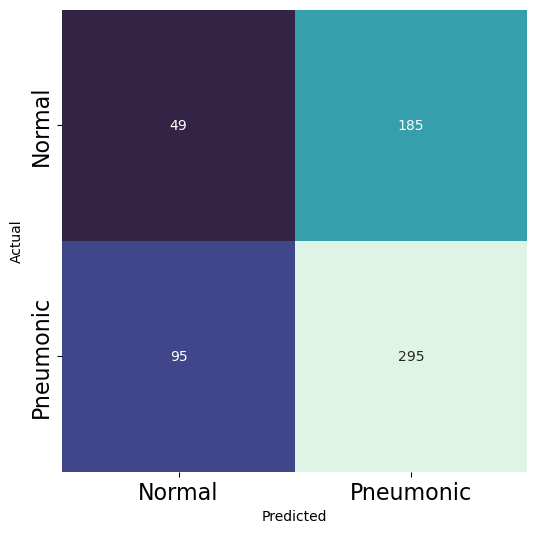

In [111]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonic'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonic'], fontsize=16)
plt.show()

In [112]:
results = imageClassifier.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [113]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [245]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.84
AUC: 0.96
Precision: 0.61
Recall: 0.76


**PREDICTING**

In [260]:

pathFile2 = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1018_virus_1706.jpeg"

def pneumoniaPrediction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.array(img)/255
    img = np.expand_dims(img, axis=0) 
    isPneumonic = imageClassifier.predict(img)[0]
    imgClass = "Normal lung" if isPneumonic<0.5 else "Pneumonic lung"
    formatted = float("{:.4f}".format(isPneumonic[0]))
    confidence = f"{formatted*100}%" if imgClass=="Pneumonic lung" else f"{100-(formatted*100)}%"
    
    classification = {
        'Prediction': imgClass,
        'Probability': formatted,
        'Confidence': confidence
    }
    print(classification)
    return classification

    

**INTEFACE**

In [ ]:
xray = gradio.inputs.Image()
label = gradio.outputs.Label(num_top_classes=1, label='dope')

interface = gradio.Interface(fn = pneumoniaPrediction,
                            title = "Pneumonia Detection using Chest X-Ray's",
                            inputs = xray,
                            outputs = 'textbox',
                            interpretation = "default")
interface.launch(debug=True, share=True)

/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:258: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.7/site-packages/gradio/outputs.py:198: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://ede6a3de7552359873.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 74ms/step
{'Prediction': 'Pneumonic lung', 'Probability': 0.9105, 'Confidence': '91.05%'}
1/1 [==============================] - 0s 69ms/step
{'Prediction': 'Normal lung', 'Probability': 0.0171, 'Confidence': '98.29%'}
1/1 [==============================] - 0s 66ms/step
{'Prediction': 'Normal lung', 'Probability': 0.4672, 'Confidence': '53.28%'}
